# Exploratory Data Analysis

Presents descriptive statistics for a public domain data set from E-Commerce Shopping

https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import datetime
import copy
import time
import os
import re
import matplotlib.pyplot as plt
import operator

from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

There are 3 files, `item_properties`, `category_tree`, and `events`, lets examine `events` first.

In [3]:
eventsFileName = 'events.csv'
df = pd.read_csv(eventsFileName)

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values(by=['visitorid'])
df = df.reset_index(drop=True)
df.set_index(['visitorid', df.index], inplace=True)

In [5]:
df

timestamp event  itemid  transactionid
visitorid                                                             
0         0       2015-09-11 20:49:49.439  view  285930            NaN
          1       2015-09-11 20:52:39.591  view  357564            NaN
          2       2015-09-11 20:55:17.175  view   67045            NaN
1         3       2015-08-13 17:46:06.444  view   72028            NaN
2         4       2015-08-07 18:17:24.375  view  342816            NaN
...                                   ...   ...     ...            ...
1407575   2756096 2015-06-10 21:46:08.922  view  121220            NaN
1407576   2756097 2015-06-03 15:01:29.991  view  356208            NaN
1407577   2756098 2015-05-17 21:48:04.867  view  427784            NaN
1407578   2756099 2015-05-17 01:21:23.288  view  188736            NaN
1407579   2756100 2015-06-24 22:22:06.978  view    2521            NaN

[2756101 rows x 4 columns]

The data is stored as a multi-index pandas table. The first level corresponds to an individual's visitor ID and the second layer is a numerical index of the information regarding the event.

The columns of are table are timestamp, event, itemid and transactionid(if a transaction was made). The types of events are as follows:

In [6]:
df.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

- `view`: The visitor has clicked the item at the timestamp.
- `addtocart`: The visitor has added the item to cart at the timestamp.
- `transaction`: The visitor has purchased the item at the timestamp and the transactionid is recorded.

# Population Description

In [7]:
num_cases = len(df.index.get_level_values(0))
pop_size = len(df.index.get_level_values(0).unique())
num_transaction = (~df.transactionid.isnull()).sum()
num_items = len(df.itemid.unique())
print(f"Dataset contains {pop_size} individuals with {num_cases} cases in an e-commerce website.")
print(f"There are {num_transaction} transactions recorded with {num_items} unique items.")

Dataset contains 1407580 individuals with 2756101 cases in an e-commerce website.
There are 22457 transactions recorded with 235061 unique items.


In [8]:
before = df.shape[0]
mask=df.duplicated()
df=df[~mask]
df.reset_index(drop=True, inplace=True)
after = df.shape[0]
print(f"There were {before - after} duplicates.")

There were 483 duplicates.


In [9]:
print('Starting Date:', df['timestamp'].min())
print('End Date:', df['timestamp'].max())

Starting Date: 2015-05-03 03:00:04.384000
End Date: 2015-09-18 02:59:47.788000


The dataset ranges from May 3rd, 2015 to September 18th, 2015.

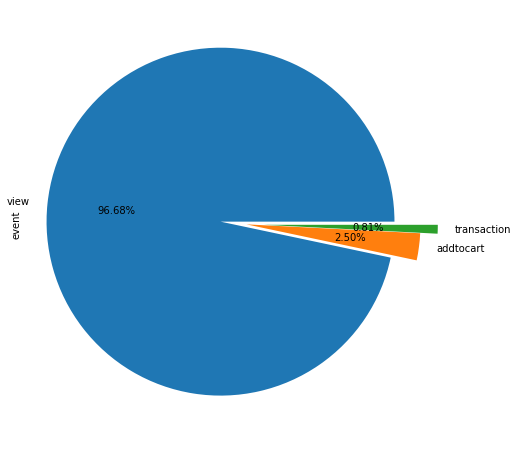

In [10]:
eventEntries = df.loc[:, 'event'].value_counts().plot.pie(figsize=(8,8), autopct='%.2f%%', explode=(0.15, 0, 0.1))
            

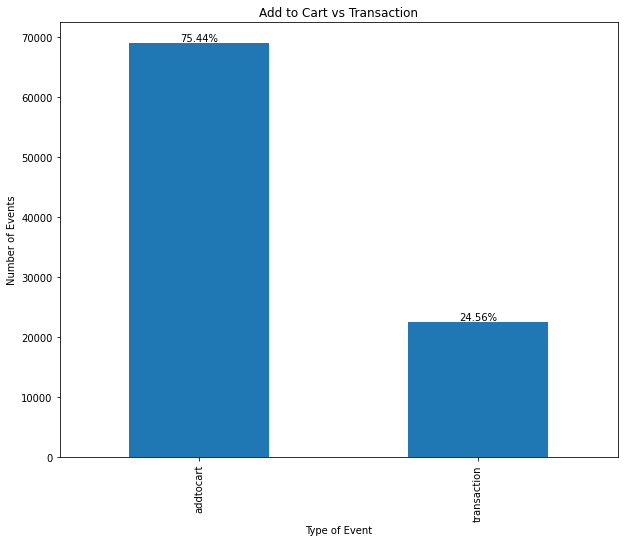

In [11]:
addtocart_vs_transaction = df.loc[:, 'event'].value_counts().drop('view').plot(kind='bar', 
                                                                               figsize=(10,8), 
                                                                               title="Add to Cart vs Transaction", 
                                                                               xlabel = "Type of Event",
                                                                               ylabel="Number of Events")

for p in addtocart_vs_transaction.containers:
    total = p.datavalues.sum()
    addtocart_vs_transaction.bar_label(p, labels=[(p.datavalues[0] / total * 100).round(2).astype(str) + "%", 
                                                  (p.datavalues[1] / total * 100).round(2).astype(str) + "%"])


In [12]:
c = df.event.value_counts()
p = df.event.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
pd.concat([c,p], axis=1, keys=['counts', '%'])

,counts,%
view,2664195,96.68%
addtocart,68966,2.5%
transaction,22457,0.81%


As seen, `view` occupies 96.68%, `add to cart` 2.5%, and `transaction` 0.81%.

Only 32.56% of `add to cart` leads to a `transaction`.

Text(0.5, 1.0, 'Top 5 items purchased')

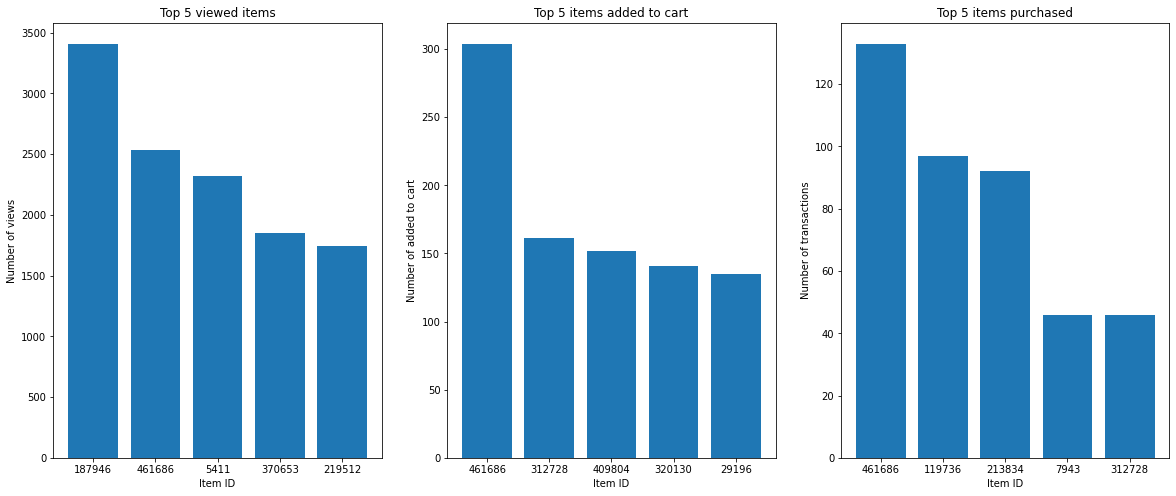

In [13]:
grouped=df.groupby('event')['itemid'].apply(list)
views = grouped['view']
addtocart = grouped['addtocart']
transaction = grouped['transaction']

unique, counts = np.unique(views, return_counts=True)
count_array = dict(zip(unique, counts))
sorted_count_array = sorted(count_array.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_array[:5]]
y=[i[1] for i in sorted_count_array[:5]]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
ax1.bar(range(5), y, tick_label=x)
ax1.set_xlabel("Item ID")
ax1.set_ylabel("Number of views")
ax1.set_title("Top 5 viewed items")

unique, counts = np.unique(addtocart, return_counts=True)
count_array = dict(zip(unique, counts))
sorted_count_array = sorted(count_array.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_array[:5]]
y=[i[1] for i in sorted_count_array[:5]]
ax2.bar(range(5), y, tick_label=x)
ax2.set_xlabel("Item ID")
ax2.set_ylabel("Number of added to cart")
ax2.set_title("Top 5 items added to cart")

unique, counts = np.unique(transaction, return_counts=True)
count_array = dict(zip(unique, counts))
sorted_count_array = sorted(count_array.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_array[:5]]
y=[i[1] for i in sorted_count_array[:5]]
ax3.bar(range(5), y, tick_label=x)
ax3.set_xlabel("Item ID")
ax3.set_ylabel("Number of transactions")
ax3.set_title("Top 5 items purchased")

As shown, items that are viewed the most do not necessarily mean that they are added to the cart or purchased the most. For example, Item IDs 187946, 5411, 370653, 219512 are within the top 5 viewed items but none are within the top 5 items added to cart or purchased. 

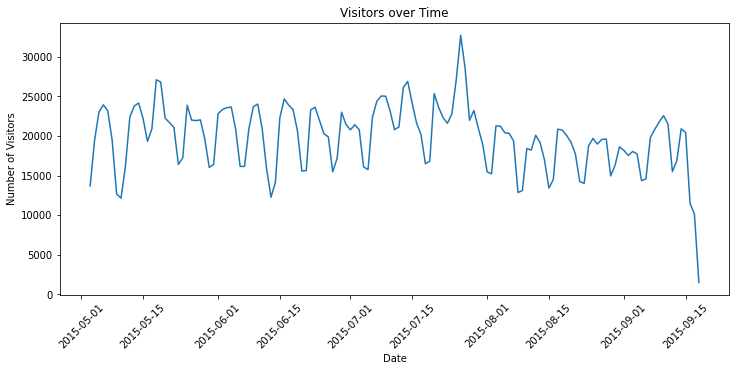

In [14]:
dateEntries = df.loc[:, 'timestamp'].dt.tz_localize(None).dt.date.value_counts().plot(figsize=(12,5),
                                                                                      title = "Visitors over Time",
                                                                                      xlabel = "Date",
                                                                                      rot = 45,
                                                                                      ylabel = "Number of Visitors")

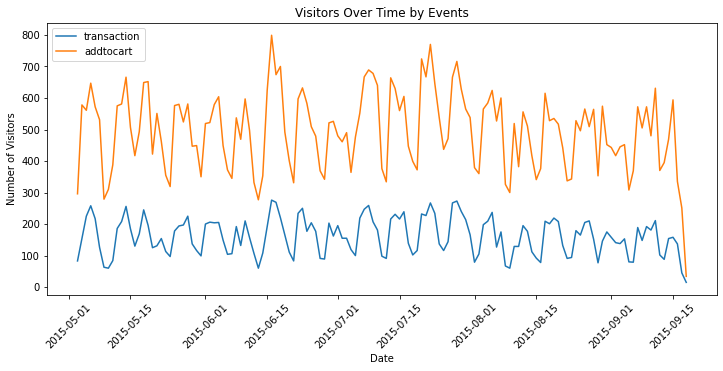

In [21]:
df[df.event == 'transaction'].loc[:, 'timestamp'].dt.tz_localize(None).dt.date.value_counts().plot(label="transaction")
df[df.event == 'addtocart'].loc[:, 'timestamp'].dt.tz_localize(None).dt.date.value_counts().plot(figsize=(12,5),rot=45, label="addtocart")
plt.title("Visitors Over Time by Events")
plt.xlabel("Date")
plt.ylabel("Number of Visitors")
plt.legend(loc="upper left")

Let's now analyze the `item_properties` and `category_tree` files.

In [16]:
items1 = pd.read_csv('item_properties_part1.csv')
items2 = pd.read_csv('item_properties_part2.csv')
df2 = pd.concat([items1, items2])
df2['timestamp'] = pd.to_datetime(df2['timestamp'], unit='ms')

In [17]:
df2

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513
...,...,...,...,...
9275898,2015-06-07 03:00:00,236931,929,n12.000
9275899,2015-08-30 03:00:00,455746,6,150169 639134
9275900,2015-08-16 03:00:00,347565,686,610834
9275901,2015-06-07 03:00:00,287231,867,769062


In [18]:
category_treeFileName = 'category_tree.csv'
df3 = pd.read_csv(category_treeFileName)

In [19]:
df3

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


Category IDs place different products with each other from `category_tree` and `item_properties`. For example, category ID 1016 is a child of parent ID 213.

As an example, here are the number of items under Category ID 1016.

In [22]:
df2.loc[(df2.property=='categoryid')&(df2.value == '1016')].head()

,timestamp,itemid,property,value
234908,2015-06-28 03:00:00,73730,categoryid,1016
430468,2015-06-28 03:00:00,201154,categoryid,1016
676270,2015-05-31 03:00:00,29689,categoryid,1016
783306,2015-05-31 03:00:00,235999,categoryid,1016
970935,2015-05-10 03:00:00,362999,categoryid,1016
